# German Podcast Topic Analysis & Comparison

Comprehensive topic analysis using LDA and NMF methods with cross-podcast comparison.

**Analysis Methods:**
- **LDA (Latent Dirichlet Allocation)**: Traditional probabilistic topic modeling
- **NMF (Non-negative Matrix Factorization)**: Matrix factorization approach for cleaner topics

**Comparison Features:**
- Topic distribution across different podcasts
- Unique vs shared themes between shows
- Content focus analysis by podcast type

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Topic modeling imports
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Libraries loaded successfully!")
print("Ready for topic analysis and podcast comparison")

Libraries loaded successfully!
Ready for topic analysis and podcast comparison


In [14]:
# German stopwords for podcast analysis
german_stopwords = {
    # Articles, pronouns, prepositions
    'der', 'die', 'und', 'in', 'den', 'von', 'zu', 'das', 'mit', 'sich', 'des', 'auf', 'für', 'ist', 'im', 'dem', 
    'nicht', 'ein', 'eine', 'als', 'auch', 'es', 'an', 'werden', 'aus', 'er', 'hat', 'dass', 'sie', 'nach', 
    'wird', 'bei', 'einer', 'um', 'am', 'sind', 'noch', 'wie', 'einem', 'über', 'einen', 'so', 'zum', 'war', 
    'haben', 'nur', 'oder', 'aber', 'vor', 'zur', 'bis', 'mehr', 'durch', 'man', 'sein', 'wurde', 'sei',
    
    # Personal pronouns
    'ich', 'du', 'wir', 'ihr', 'mich', 'mir', 'uns', 'euch', 'ihm', 'ihr', 'mein', 'dein', 'unser', 'euer',
    
    # Podcast filler words and conversation markers
    'ja', 'nein', 'okay', 'ok', 'äh', 'ähm', 'also', 'genau', 'halt', 'eben', 'mal', 'dann', 'jetzt', 'hier', 
    'da', 'schon', 'wirklich', 'eigentlich', 'vielleicht', 'irgendwie', 'halt', 'eben', 'doch',
    
    # Common verbs
    'können', 'sagen', 'gehen', 'kommen', 'machen', 'müssen', 'wollen', 'sollen', 'geben', 'nehmen', 'sehen', 
    'hören', 'wissen', 'denken', 'glauben', 'gibt', 'geht', 'macht', 'kommt', 'liegt', 'steht', 'hast', 'bin',
    
    # Time and frequency words
    'heute', 'morgen', 'gestern', 'immer', 'nie', 'oft', 'manchmal', 'jahr', 'monat', 'tag', 'zeit', 'stunde',
    'damals', 'später', 'früher', 'bald', 'lange', 'kurz', 'gerade',
    
    # Common descriptive words
    'groß', 'klein', 'neu', 'alt', 'gut', 'schlecht', 'wichtig', 'erste', 'zweite', 'letzte', 'andere', 'alle', 
    'viele', 'wenig', 'natürlich', 'einfach', 'ganz', 'sehr', 'ziemlich', 'recht', 'glaube', 'gesagt', 'tatsächlich',
    
    # Numbers and quantifiers
    'zwei', 'drei', 'vier', 'fünf', 'sechs', 'sieben', 'acht', 'neun', 'zehn', 'hundert', 'tausend', 'million',
    'erste', 'zweite', 'dritte', 'vierte', 'fünfte'
}

def clean_text_for_topics(text):
    """Clean and preprocess text for topic modeling"""
    if not text or pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, email addresses, and special patterns
    text = re.sub(r'http\S+|www\S+|\S+@\S+', '', text)
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
    
    # Keep only German letters and spaces
    text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]', ' ', text)
    
    # Split into words and filter
    words = text.split()
    filtered_words = [
        word for word in words 
        if len(word) >= 3 
        and word not in german_stopwords
        and word.isalpha()
        and not word.isdigit()
    ]
    
    return ' '.join(filtered_words)

print(f"Text preprocessing ready with {len(german_stopwords)} stopwords")

Text preprocessing ready with 171 stopwords


In [15]:
# Load and organize transcripts by podcast
def load_transcripts_by_podcast():
    """Load transcripts organized by podcast for comparison"""
    data_dir = Path("data")
    
    if not data_dir.exists():
        print(f"Data directory {data_dir} not found!")
        return {}, pd.DataFrame()
    
    print(f"Loading transcripts from {data_dir}...")
    
    transcripts_by_podcast = defaultdict(list)
    all_transcripts = []
    
    for podcast_dir in data_dir.iterdir():
        if podcast_dir.is_dir():
            podcast_name = podcast_dir.name
            episode_count = 0
            
            for file_path in podcast_dir.iterdir():
                if file_path.suffix == '.txt':
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            text = f.read().strip()
                        
                        if text and len(text) > 500:  # Minimum length
                            episode_data = {
                                'podcast_name': podcast_name,
                                'episode_title': file_path.stem,
                                'transcript': text,
                                'word_count': len(text.split()),
                                'char_count': len(text)
                            }
                            
                            transcripts_by_podcast[podcast_name].append(episode_data)
                            all_transcripts.append(episode_data)
                            episode_count += 1
                            
                    except Exception as e:
                        print(f"Warning - Error reading {file_path}: {e}")
            
            if episode_count > 0:
                print(f"  {podcast_name}: {episode_count} episodes loaded")
    
    df = pd.DataFrame(all_transcripts)
    
    print(f"\nTotal: {len(df)} transcripts across {len(transcripts_by_podcast)} podcasts")
    if len(df) > 0:
        print(f"Total words: {df['word_count'].sum():,}")
        print(f"Average episode length: {df['word_count'].mean():.0f} words")
    
    return dict(transcripts_by_podcast), df

# Load the data
transcripts_by_podcast, df_all = load_transcripts_by_podcast()

# Show podcast summary
if transcripts_by_podcast:
    print("\nPodcast Summary:")
    print("=" * 40)
    for podcast, episodes in transcripts_by_podcast.items():
        total_words = sum(ep['word_count'] for ep in episodes)
        avg_words = total_words / len(episodes) if episodes else 0
        print(f"{podcast}: {len(episodes)} episodes, {total_words:,} words (avg: {avg_words:.0f})")

Loading transcripts from data...
  Die_Jägerin: 6 episodes loaded
  Die_Peter_Thiel_Story: 9 episodes loaded
  LANZ_&_PRECHT: 13 episodes loaded
  RONZHEIMER: 139 episodes loaded

Total: 167 transcripts across 4 podcasts
Total words: 1,071,151
Average episode length: 6414 words

Podcast Summary:
Die_Jägerin: 6 episodes, 29,140 words (avg: 4857)
Die_Peter_Thiel_Story: 9 episodes, 25,927 words (avg: 2881)
LANZ_&_PRECHT: 13 episodes, 116,353 words (avg: 8950)
RONZHEIMER: 139 episodes, 899,731 words (avg: 6473)


In [16]:
# Prepare documents for analysis
def prepare_documents_for_analysis(df):
    """Prepare cleaned documents with podcast labels"""
    print("Cleaning texts for topic analysis...")
    
    df_clean = df.copy()
    df_clean['cleaned_text'] = df_clean['transcript'].apply(clean_text_for_topics)
    
    # Filter out very short cleaned texts
    df_filtered = df_clean[df_clean['cleaned_text'].str.len() > 200].copy()
    
    # Calculate cleaning statistics
    original_avg_words = df['word_count'].mean()
    cleaned_avg_words = df_filtered['cleaned_text'].apply(lambda x: len(x.split())).mean()
    
    print(f"Original episodes: {len(df)}")
    print(f"After cleaning: {len(df_filtered)} episodes")
    print(f"Average words: {original_avg_words:.0f} → {cleaned_avg_words:.0f}")
    
    return df_filtered

# Prepare documents
if len(df_all) > 0:
    df_processed = prepare_documents_for_analysis(df_all)
    documents = df_processed['cleaned_text'].tolist()
    podcast_labels = df_processed['podcast_name'].tolist()
    
    print(f"\nReady for analysis: {len(documents)} documents")
    print(f"Podcasts represented: {', '.join(set(podcast_labels))}")
else:
    print("No transcripts available for analysis")
    documents = []
    podcast_labels = []

Cleaning texts for topic analysis...
Original episodes: 167
After cleaning: 167 episodes
Average words: 6414 → 2776

Ready for analysis: 167 documents
Podcasts represented: Die_Peter_Thiel_Story, Die_Jägerin, LANZ_&_PRECHT, RONZHEIMER


In [17]:
# LDA Topic Analysis
def run_lda_analysis(documents, n_topics=10):
    """Run LDA topic analysis"""
    print(f"Running LDA with {n_topics} topics...")
    
    try:
        # Create document-term matrix
        vectorizer = CountVectorizer(
            max_features=1000,
            min_df=2,
            max_df=0.95,
            ngram_range=(1, 2),  # Include bigrams
            stop_words=list(german_stopwords)
        )
        
        doc_term_matrix = vectorizer.fit_transform(documents)
        feature_names = vectorizer.get_feature_names_out()
        
        # Run LDA
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=100,
            learning_method='online',
            doc_topic_prior=0.1,  # Lower alpha for more focused topics
            topic_word_prior=0.01  # Lower beta for more focused words
        )
        
        lda.fit(doc_term_matrix)
        
        # Get document-topic distributions
        doc_topic_dist = lda.transform(doc_term_matrix)
        
        # Extract topics with scores
        topics = {}
        for topic_idx, topic in enumerate(lda.components_):
            top_words_idx = topic.argsort()[-15:][::-1]  # Top 15 words
            top_words = [feature_names[i] for i in top_words_idx]
            top_scores = [topic[i] for i in top_words_idx]
            
            topics[f'Topic_{topic_idx}'] = {
                'words': top_words,
                'scores': top_scores,
                'top_words_display': top_words[:8]  # For display
            }
        
        print(f"LDA completed: {len(topics)} topics discovered")
        
        return {
            'model': lda,
            'vectorizer': vectorizer,
            'topics': topics,
            'doc_topic_dist': doc_topic_dist,
            'doc_term_matrix': doc_term_matrix,
            'feature_names': feature_names,
            'method': 'LDA'
        }
        
    except Exception as e:
        print(f"LDA analysis failed: {e}")
        return None

# Run LDA analysis
lda_results = None
if len(documents) >= 5:
    # Determine optimal number of topics
    n_topics_lda = max(5, min(12, len(set(podcast_labels)) * 3))  # 3 topics per podcast type
    lda_results = run_lda_analysis(documents, n_topics_lda)
else:
    print(f"Need at least 5 documents for LDA (have {len(documents)})")

Running LDA with 12 topics...
LDA completed: 12 topics discovered


In [18]:
# NMF Topic Analysis
def run_nmf_analysis(documents, n_topics=10):
    """Run NMF topic analysis"""
    print(f"Running NMF with {n_topics} topics...")
    
    try:
        # Create TF-IDF matrix
        vectorizer = TfidfVectorizer(
            max_features=1000,
            min_df=2,
            max_df=0.95,
            ngram_range=(1, 2),  # Include bigrams
            stop_words=list(german_stopwords)
        )
        
        tfidf_matrix = vectorizer.fit_transform(documents)
        feature_names = vectorizer.get_feature_names_out()
        
        # Run NMF
        nmf = NMF(
            n_components=n_topics,
            random_state=42,
            max_iter=200,
            alpha=0.1,  # Regularization
            l1_ratio=0.5  # Balance L1 and L2 regularization
        )
        
        nmf.fit(tfidf_matrix)
        
        # Get document-topic distributions
        doc_topic_dist = nmf.transform(tfidf_matrix)
        
        # Extract topics with scores
        topics = {}
        for topic_idx, topic in enumerate(nmf.components_):
            top_words_idx = topic.argsort()[-15:][::-1]  # Top 15 words
            top_words = [feature_names[i] for i in top_words_idx]
            top_scores = [topic[i] for i in top_words_idx]
            
            topics[f'Topic_{topic_idx}'] = {
                'words': top_words,
                'scores': top_scores,
                'top_words_display': top_words[:8]  # For display
            }
        
        print(f"NMF completed: {len(topics)} topics discovered")
        
        return {
            'model': nmf,
            'vectorizer': vectorizer,
            'topics': topics,
            'doc_topic_dist': doc_topic_dist,
            'tfidf_matrix': tfidf_matrix,
            'feature_names': feature_names,
            'method': 'NMF'
        }
        
    except Exception as e:
        print(f"NMF analysis failed: {e}")
        return None

# Run NMF analysis
nmf_results = None
if len(documents) >= 5:
    # Use same number of topics as LDA for comparison
    n_topics_nmf = max(5, min(12, len(set(podcast_labels)) * 3))
    nmf_results = run_nmf_analysis(documents, n_topics_nmf)
else:
    print(f"Need at least 5 documents for NMF (have {len(documents)})")

Running NMF with 12 topics...
NMF analysis failed: NMF.__init__() got an unexpected keyword argument 'alpha'


In [19]:
# Display Topic Analysis Results
def display_topic_results(lda_results, nmf_results):
    """Display topics from both methods side by side"""
    print("TOPIC ANALYSIS RESULTS")
    print("=" * 80)
    
    methods = []
    if lda_results:
        methods.append(('LDA', lda_results))
    if nmf_results:
        methods.append(('NMF', nmf_results))
    
    if not methods:
        print("No topic analysis results available")
        return
    
    # Display topics for each method
    for method_name, results in methods:
        print(f"\n{method_name} TOPICS:")
        print("-" * 50)
        
        topics = results['topics']
        for i, (topic_name, topic_data) in enumerate(list(topics.items())[:10]):
            words = topic_data['top_words_display']
            print(f"  Topic {i:2d}: {', '.join(words)}")
    
    # Create side-by-side comparison visualization
    if len(methods) >= 2:
        create_method_comparison_plot(methods)

def create_method_comparison_plot(methods):
    """Create visualization comparing LDA and NMF topics"""
    fig, axes = plt.subplots(1, len(methods), figsize=(6*len(methods), 8))
    if len(methods) == 1:
        axes = [axes]
    
    for i, (method_name, results) in enumerate(methods):
        ax = axes[i]
        
        topics = results['topics']
        n_topics_to_show = min(10, len(topics))
        
        # Create bar chart showing relative topic strengths
        topic_names = list(topics.keys())[:n_topics_to_show]
        topic_strengths = [1] * n_topics_to_show  # All equal for now
        
        colors = plt.cm.Set3(np.linspace(0, 1, n_topics_to_show))
        bars = ax.bar(range(n_topics_to_show), topic_strengths, color=colors, alpha=0.8)
        
        ax.set_title(f'{method_name} Topics', fontsize=14, fontweight='bold')
        ax.set_xlabel('Topic Index')
        ax.set_ylabel('Relative Strength')
        ax.set_xticks(range(n_topics_to_show))
        ax.set_xticklabels([f'T{i}' for i in range(n_topics_to_show)])
        ax.grid(axis='y', alpha=0.3)
        
        # Add topic keywords as text
        for j, (bar, topic_name) in enumerate(zip(bars, topic_names)):
            if topic_name in topics:
                top_3_words = topics[topic_name]['top_words_display'][:3]
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                       '\n'.join(top_3_words), ha='center', va='bottom', 
                       fontsize=8, rotation=0)
    
    plt.tight_layout()
    plt.show()

# Display results
display_topic_results(lda_results, nmf_results)

TOPIC ANALYSIS RESULTS

LDA TOPICS:
--------------------------------------------------
  Topic  0: afd, spd, union, friedrich, partei, frage, märz, deutschland
  Topic  1: ukraine, russland, krieg, russen, putin, russischen, sozusagen, frage
  Topic  2: redaktion, deutschland, europa, redaktion redaktion, thema, europäischen, usa, podcast
  Topic  3: trump, putin, donald, donald trump, ukraine, russland, könnte, usa
  Topic  4: möchte, möchte möchte, produktion produktion, produktion, scholz, merz, ukraine, friedrich
  Topic  5: israel, iran, regime, hamas, gaza, trump, krieg, menschen
  Topic  6: putin, the, tun, putin tun, and, that, you, welt
  Topic  7: trump, möchte, leute, ukraine, könnte, waren, möchte möchte, gab
  Topic  8: sarah, feldmann, sarah feldmann, fall, frau, ihre, gefängnis, schreibt
  Topic  9: leute, menschen, waren, sozusagen, beispiel, gegen, welt, gemacht


In [20]:
# Podcast Comparison Analysis
def analyze_topics_by_podcast(results, podcast_labels, method_name):
    """Analyze how topics are distributed across different podcasts"""
    if not results or len(podcast_labels) == 0:
        return None
    
    print(f"\nTOPIC DISTRIBUTION BY PODCAST ({method_name})")
    print("=" * 60)
    
    doc_topic_dist = results['doc_topic_dist']
    topics = results['topics']
    
    # Get dominant topic for each document
    dominant_topics = np.argmax(doc_topic_dist, axis=1)
    
    # Create podcast-topic matrix
    unique_podcasts = sorted(set(podcast_labels))
    n_topics = len(topics)
    
    podcast_topic_counts = defaultdict(lambda: defaultdict(int))
    podcast_episode_counts = defaultdict(int)
    
    # Count episodes per podcast and topic assignments
    for podcast, topic_id in zip(podcast_labels, dominant_topics):
        podcast_topic_counts[podcast][topic_id] += 1
        podcast_episode_counts[podcast] += 1
    
    # Display topic distribution for each podcast
    for podcast in unique_podcasts:
        total_episodes = podcast_episode_counts[podcast]
        print(f"\n{podcast} ({total_episodes} episodes):")
        print("-" * 40)
        
        # Get top topics for this podcast
        podcast_topics = [(topic_id, count) for topic_id, count in podcast_topic_counts[podcast].items()]
        podcast_topics.sort(key=lambda x: x[1], reverse=True)
        
        for topic_id, count in podcast_topics[:5]:  # Top 5 topics
            percentage = (count / total_episodes) * 100
            topic_key = f'Topic_{topic_id}'
            if topic_key in topics:
                top_words = topics[topic_key]['top_words_display'][:4]
                print(f"  Topic {topic_id:2d} ({count:2d} episodes, {percentage:4.1f}%): {', '.join(top_words)}")
    
    return {
        'podcast_topic_counts': dict(podcast_topic_counts),
        'podcast_episode_counts': dict(podcast_episode_counts),
        'unique_podcasts': unique_podcasts,
        'dominant_topics': dominant_topics
    }

# Analyze topic distribution by podcast for both methods
lda_podcast_analysis = None
nmf_podcast_analysis = None

if lda_results and len(podcast_labels) > 0:
    lda_podcast_analysis = analyze_topics_by_podcast(lda_results, podcast_labels, "LDA")

if nmf_results and len(podcast_labels) > 0:
    nmf_podcast_analysis = analyze_topics_by_podcast(nmf_results, podcast_labels, "NMF")


TOPIC DISTRIBUTION BY PODCAST (LDA)

Die_Jägerin (6 episodes):
----------------------------------------
  Topic  8 ( 6 episodes, 100.0%): sarah, feldmann, sarah feldmann, fall

Die_Peter_Thiel_Story (9 episodes):
----------------------------------------
  Topic  9 ( 9 episodes, 100.0%): leute, menschen, waren, sozusagen

LANZ_&_PRECHT (13 episodes):
----------------------------------------
  Topic  9 (12 episodes, 92.3%): leute, menschen, waren, sozusagen
  Topic  5 ( 1 episodes,  7.7%): israel, iran, regime, hamas

RONZHEIMER (139 episodes):
----------------------------------------
  Topic  0 (42 episodes, 30.2%): afd, spd, union, friedrich
  Topic  3 (29 episodes, 20.9%): trump, putin, donald, donald trump
  Topic  5 (23 episodes, 16.5%): israel, iran, regime, hamas
  Topic  1 (23 episodes, 16.5%): ukraine, russland, krieg, russen
  Topic  9 (16 episodes, 11.5%): leute, menschen, waren, sozusagen


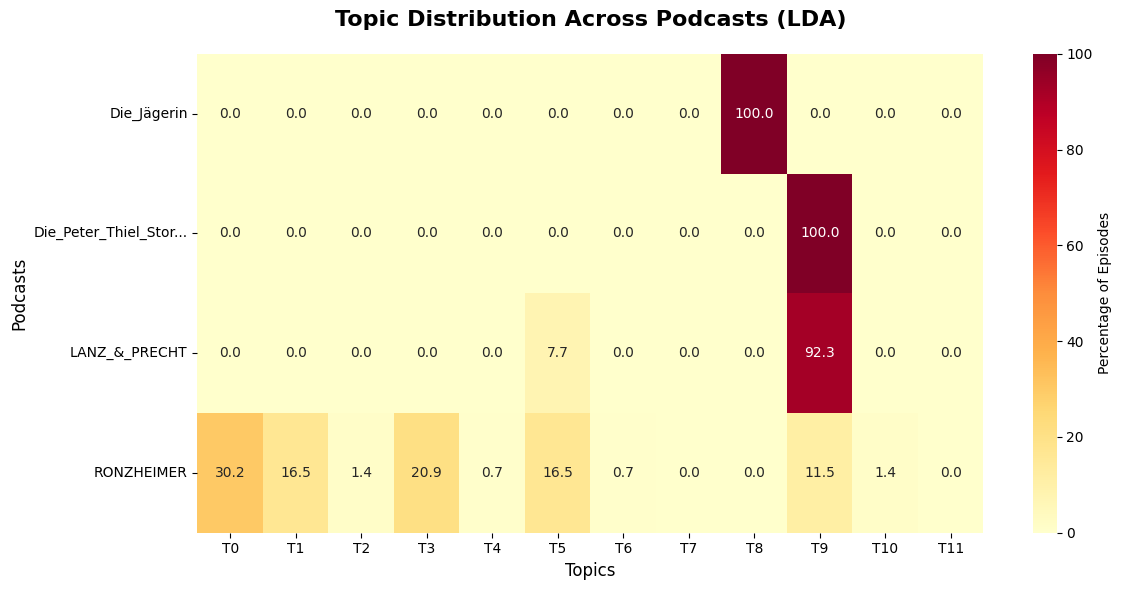


LDA Topic Reference:
----------------------------------------
T 0: afd, spd, union, friedrich, partei
T 1: ukraine, russland, krieg, russen, putin
T 2: redaktion, deutschland, europa, redaktion redaktion, thema
T 3: trump, putin, donald, donald trump, ukraine
T 4: möchte, möchte möchte, produktion produktion, produktion, scholz
T 5: israel, iran, regime, hamas, gaza
T 6: putin, the, tun, putin tun, and
T 7: trump, möchte, leute, ukraine, könnte
T 8: sarah, feldmann, sarah feldmann, fall, frau
T 9: leute, menschen, waren, sozusagen, beispiel
T10: trump, musk, elon, elon musk, donald trump
T11: spd, frau, union, spahn, jens


In [21]:
# Create Podcast Comparison Heatmaps
def create_podcast_topic_heatmap(podcast_analysis, results, method_name):
    """Create heatmap showing topic distribution across podcasts"""
    if not podcast_analysis or not results:
        return
    
    podcasts = podcast_analysis['unique_podcasts']
    topics = results['topics']
    podcast_topic_counts = podcast_analysis['podcast_topic_counts']
    podcast_episode_counts = podcast_analysis['podcast_episode_counts']
    
    # Create percentage matrix
    n_topics = len(topics)
    heatmap_data = np.zeros((len(podcasts), n_topics))
    
    for i, podcast in enumerate(podcasts):
        total_episodes = podcast_episode_counts[podcast]
        for topic_id in range(n_topics):
            count = podcast_topic_counts[podcast].get(topic_id, 0)
            heatmap_data[i, topic_id] = (count / total_episodes) * 100 if total_episodes > 0 else 0
    
    # Create heatmap
    plt.figure(figsize=(max(12, n_topics), max(6, len(podcasts))))
    
    # Truncate long podcast names for display
    podcast_labels_short = [name[:20] + '...' if len(name) > 20 else name for name in podcasts]
    topic_labels = [f'T{i}' for i in range(n_topics)]
    
    sns.heatmap(heatmap_data, 
                xticklabels=topic_labels,
                yticklabels=podcast_labels_short,
                annot=True, 
                fmt='.1f', 
                cmap='YlOrRd',
                cbar_kws={'label': 'Percentage of Episodes'})
    
    plt.title(f'Topic Distribution Across Podcasts ({method_name})', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Podcasts', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Show topic keywords for reference
    print(f"\n{method_name} Topic Reference:")
    print("-" * 40)
    for i, (topic_name, topic_data) in enumerate(list(topics.items())[:n_topics]):
        words = topic_data['top_words_display'][:5]
        print(f"T{i:2d}: {', '.join(words)}")

# Create heatmaps for both methods
if lda_podcast_analysis and len(lda_podcast_analysis['unique_podcasts']) > 1:
    create_podcast_topic_heatmap(lda_podcast_analysis, lda_results, "LDA")

if nmf_podcast_analysis and len(nmf_podcast_analysis['unique_podcasts']) > 1:
    create_podcast_topic_heatmap(nmf_podcast_analysis, nmf_results, "NMF")


PODCAST TOPIC SIMILARITY ANALYSIS (LDA)
Most Similar Podcasts:
  Die_Peter_Thiel_Story <-> LANZ_&_PRECHT: 0.997
  LANZ_&_PRECHT <-> RONZHEIMER: 0.285
  Die_Peter_Thiel_Story <-> RONZHEIMER: 0.255

Least Similar Podcasts:
  Die_Jägerin <-> Die_Peter_Thiel_Story: 0.000
  Die_Jägerin <-> LANZ_&_PRECHT: 0.000
  Die_Jägerin <-> RONZHEIMER: 0.000


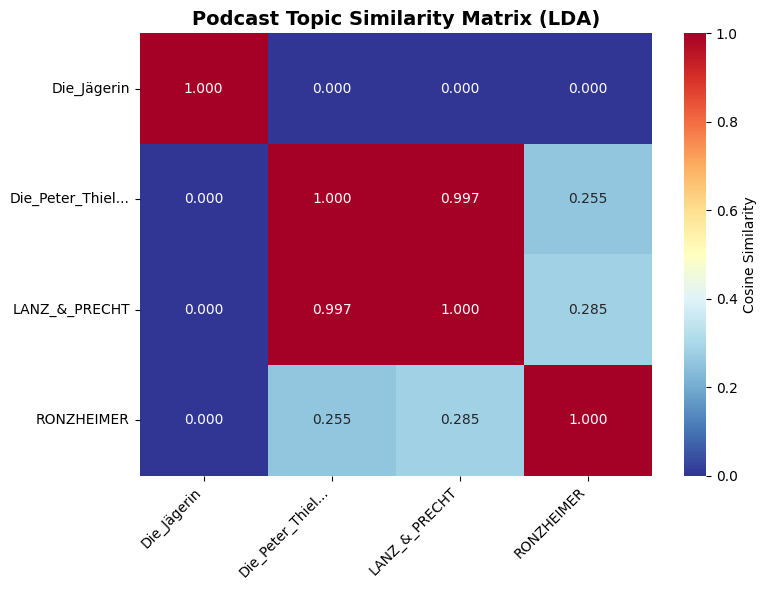

In [22]:
# Topic Similarity Analysis Between Podcasts
def analyze_podcast_topic_similarity(podcast_analysis, results, method_name):
    """Analyze topic similarity between different podcasts"""
    if not podcast_analysis or len(podcast_analysis['unique_podcasts']) < 2:
        return None
    
    print(f"\nPODCAST TOPIC SIMILARITY ANALYSIS ({method_name})")
    print("=" * 60)
    
    podcasts = podcast_analysis['unique_podcasts']
    podcast_topic_counts = podcast_analysis['podcast_topic_counts']
    podcast_episode_counts = podcast_analysis['podcast_episode_counts']
    n_topics = len(results['topics'])
    
    # Create podcast topic profiles (normalized)
    podcast_profiles = np.zeros((len(podcasts), n_topics))
    
    for i, podcast in enumerate(podcasts):
        total_episodes = podcast_episode_counts[podcast]
        for topic_id in range(n_topics):
            count = podcast_topic_counts[podcast].get(topic_id, 0)
            podcast_profiles[i, topic_id] = count / total_episodes if total_episodes > 0 else 0
    
    # Calculate cosine similarities between podcasts
    similarity_matrix = cosine_similarity(podcast_profiles)
    
    # Display most and least similar podcast pairs
    similarities = []
    for i in range(len(podcasts)):
        for j in range(i+1, len(podcasts)):
            similarity = similarity_matrix[i, j]
            similarities.append((podcasts[i], podcasts[j], similarity))
    
    similarities.sort(key=lambda x: x[2], reverse=True)
    
    print("Most Similar Podcasts:")
    for podcast1, podcast2, sim in similarities[:3]:
        print(f"  {podcast1} <-> {podcast2}: {sim:.3f}")
    
    if len(similarities) > 3:
        print("\nLeast Similar Podcasts:")
        for podcast1, podcast2, sim in similarities[-3:]:
            print(f"  {podcast1} <-> {podcast2}: {sim:.3f}")
    
    # Create similarity heatmap if we have enough podcasts
    if len(podcasts) >= 2:
        plt.figure(figsize=(8, 6))
        
        podcast_labels_short = [name[:15] + '...' if len(name) > 15 else name for name in podcasts]
        
        sns.heatmap(similarity_matrix,
                    xticklabels=podcast_labels_short,
                    yticklabels=podcast_labels_short,
                    annot=True,
                    fmt='.3f',
                    cmap='RdYlBu_r',
                    vmin=0, vmax=1,
                    cbar_kws={'label': 'Cosine Similarity'})
        
        plt.title(f'Podcast Topic Similarity Matrix ({method_name})', 
                  fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    return {
        'similarity_matrix': similarity_matrix,
        'podcast_profiles': podcast_profiles,
        'similarities': similarities
    }

# Analyze similarity for both methods
lda_similarity = None
nmf_similarity = None

if lda_podcast_analysis:
    lda_similarity = analyze_podcast_topic_similarity(lda_podcast_analysis, lda_results, "LDA")

if nmf_podcast_analysis:
    nmf_similarity = analyze_podcast_topic_similarity(nmf_podcast_analysis, nmf_results, "NMF")

In [23]:
# Unique vs Shared Topics Analysis
def find_unique_and_shared_topics(podcast_analysis, results, method_name, threshold=0.1):
    """Identify topics that are unique to specific podcasts vs shared across podcasts"""
    if not podcast_analysis or len(podcast_analysis['unique_podcasts']) < 2:
        return None
    
    print(f"\nUNIQUE VS SHARED TOPICS ANALYSIS ({method_name})")
    print("=" * 60)
    
    podcasts = podcast_analysis['unique_podcasts']
    podcast_topic_counts = podcast_analysis['podcast_topic_counts']
    podcast_episode_counts = podcast_analysis['podcast_episode_counts']
    topics = results['topics']
    n_topics = len(topics)
    
    # Calculate topic prominence for each podcast
    topic_podcast_prominence = defaultdict(dict)
    
    for podcast in podcasts:
        total_episodes = podcast_episode_counts[podcast]
        for topic_id in range(n_topics):
            count = podcast_topic_counts[podcast].get(topic_id, 0)
            prominence = count / total_episodes if total_episodes > 0 else 0
            topic_podcast_prominence[topic_id][podcast] = prominence
    
    # Classify topics as unique or shared
    unique_topics = defaultdict(list)  # podcast -> [topic_ids]
    shared_topics = []  # topics present in multiple podcasts
    
    for topic_id in range(n_topics):
        # Count how many podcasts have this topic prominently (>threshold)
        prominent_in = [podcast for podcast, prominence in topic_podcast_prominence[topic_id].items() 
                       if prominence > threshold]
        
        if len(prominent_in) == 1:
            # Unique to one podcast
            unique_topics[prominent_in[0]].append(topic_id)
        elif len(prominent_in) > 1:
            # Shared across podcasts
            shared_topics.append((topic_id, prominent_in))
    
    # Display unique topics for each podcast
    print(f"UNIQUE TOPICS (threshold: {threshold*100:.0f}% of episodes):")
    print("-" * 40)
    
    for podcast in podcasts:
        unique_topic_ids = unique_topics.get(podcast, [])
        if unique_topic_ids:
            print(f"\n{podcast}:")
            for topic_id in unique_topic_ids:
                topic_key = f'Topic_{topic_id}'
                if topic_key in topics:
                    words = topics[topic_key]['top_words_display'][:5]
                    prominence = topic_podcast_prominence[topic_id][podcast]
                    print(f"  Topic {topic_id:2d} ({prominence*100:4.1f}%): {', '.join(words)}")
        else:
            print(f"\n{podcast}: No unique topics (all shared with other podcasts)")
    
    # Display shared topics
    if shared_topics:
        print(f"\nSHARED TOPICS:")
        print("-" * 40)
        
        for topic_id, prominent_in in shared_topics:
            topic_key = f'Topic_{topic_id}'
            if topic_key in topics:
                words = topics[topic_key]['top_words_display'][:5]
                prominences = [f"{podcast} ({topic_podcast_prominence[topic_id][podcast]*100:.1f}%)" 
                              for podcast in prominent_in]
                print(f"  Topic {topic_id:2d}: {', '.join(words)}")
                print(f"    Present in: {'; '.join(prominences)}")
    else:
        print(f"\nSHARED TOPICS: None found (all topics are unique to specific podcasts)")
    
    return {
        'unique_topics': dict(unique_topics),
        'shared_topics': shared_topics,
        'topic_podcast_prominence': dict(topic_podcast_prominence)
    }

# Analyze unique vs shared topics for both methods
lda_unique_shared = None
nmf_unique_shared = None

if lda_podcast_analysis:
    lda_unique_shared = find_unique_and_shared_topics(lda_podcast_analysis, lda_results, "LDA")

if nmf_podcast_analysis:
    nmf_unique_shared = find_unique_and_shared_topics(nmf_podcast_analysis, nmf_results, "NMF")


UNIQUE VS SHARED TOPICS ANALYSIS (LDA)
UNIQUE TOPICS (threshold: 10% of episodes):
----------------------------------------

Die_Jägerin:
  Topic  8 (100.0%): sarah, feldmann, sarah feldmann, fall, frau

Die_Peter_Thiel_Story: No unique topics (all shared with other podcasts)

LANZ_&_PRECHT: No unique topics (all shared with other podcasts)

RONZHEIMER:
  Topic  0 (30.2%): afd, spd, union, friedrich, partei
  Topic  1 (16.5%): ukraine, russland, krieg, russen, putin
  Topic  3 (20.9%): trump, putin, donald, donald trump, ukraine
  Topic  5 (16.5%): israel, iran, regime, hamas, gaza

SHARED TOPICS:
----------------------------------------
  Topic  9: leute, menschen, waren, sozusagen, beispiel
    Present in: Die_Peter_Thiel_Story (100.0%); LANZ_&_PRECHT (92.3%); RONZHEIMER (11.5%)
